In [1]:
import torch
import sys
sys.path.insert(0, "../../")
import matplotlib.pyplot as plt
import numpy as np
from classes.nn_classes import train_model, NNmodel
from torch.utils.data import Dataset, DataLoader

In [2]:
class ClusterDataset(Dataset):
    def __init__(self, data_from_file, label_index=1) -> None:
        super().__init__()
        self.data = torch.tensor(np.array([data[0] for data in data_from_file]),dtype=torch.float32)
        self.labels = torch.tensor(np.array([data[label_index] for data in data_from_file]),dtype=torch.float32)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [3]:
data_flat = np.loadtxt('../pos_e1_e2_e3_1000.txt')
data_in_file = [[d[:24].reshape(12,2),d[24],d[25],d[26]] for d in data_flat]

ENERGY_LABEL = 3

dataset_train = ClusterDataset(data_in_file[0:799], label_index=ENERGY_LABEL)
dataset_val = ClusterDataset(data_in_file[799:899], label_index=ENERGY_LABEL)
dataset_test = ClusterDataset(data_in_file[899:999], label_index=ENERGY_LABEL)

In [4]:
class LJGNN(torch.nn.Module):
    def __init__(self, eps=0.5, sigma_squared=0.03, r0=1.6, eInf=0.1, A=0.9) -> None:
        super().__init__()
        self.A = torch.nn.Parameter(torch.tensor(float(A)))
        self.eps = torch.nn.Parameter(torch.tensor(float(eps)))
        self.r0 = torch.nn.Parameter(torch.tensor(float(r0)))
        self.sigma_squared = torch.nn.Parameter(torch.tensor(float(sigma_squared)))
        self.epsinf = torch.nn.Parameter(torch.tensor(float(eInf)))
    
    def _V(self, r):
        t1 = self.eps*torch.exp(-(r - self.r0)**2/(2.0*self.sigma_squared))
        t2 = (1.0/r)**12 - 2.0*(1.0/r)**6
        return self.A*(t2-t1) + self.epsinf
    
    def forward(self, coords):
        pairwise_distances = torch.stack([torch.pdist(coords[i]) for i in range(coords.size(0))])
        return torch.sum(self._V(pairwise_distances), dim=1)

class Pot_NN(torch.nn.Module):
    def __init__(self, num_hidden_layers=4, dim_hiddens=15, activation_func=torch.nn.Softplus(), bias=True) -> None:
        super().__init__()
        self.hidden_layers = torch.nn.ParameterList()
        self.input_layer = torch.nn.Linear(1, dim_hiddens, bias=bias, dtype=torch.float)
        self.output_layer = torch.nn.Linear(dim_hiddens, 1, bias=bias, dtype=torch.float)
        self.activation_func = activation_func
        for num in range(num_hidden_layers):
            self.hidden_layers.append(torch.nn.Linear(dim_hiddens, dim_hiddens, bias=bias, dtype=torch.float))

    def _V(self, r):
        pot = self.activation_func(self.input_layer(r))
        for layer in self.hidden_layers:
            pot = self.activation_func(layer(pot))
        return self.output_layer(pot)
    
    def forward(self, coords):
        pairwise_distances = torch.stack([torch.pdist(coords[i]) for i in range(coords.size(0))]).unsqueeze(-1)
        #print(torch.sum(self._V(pairwise_distances), dim=1).view(-1))
        return torch.sum(self._V(pairwise_distances), dim=1).view(-1)

In [15]:
train_loader = DataLoader(dataset=dataset_train, batch_size=20, shuffle=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=100, shuffle=True)

In [16]:
epochs = 2000
patience= 200
models = [Pot_NN(num_hidden_layers=4, dim_hiddens=16)]#, Pot_NN(num_hidden_layers=4, dim_hiddens=16), LJGNN()]

model_losses = []
for model in models:
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
    train_losses, val_losses, test_loss = train_model(epochs=epochs, model=model, 
                                                      train_loader=train_loader, 
                                                      val_loader=val_loader, 
                                                      optimizer=optimizer,
                                                      test_loader=test_loader, 
                                                      early_stopping=True,
                                                      patience=patience)
    model_losses.append([train_losses, val_losses, test_loss])

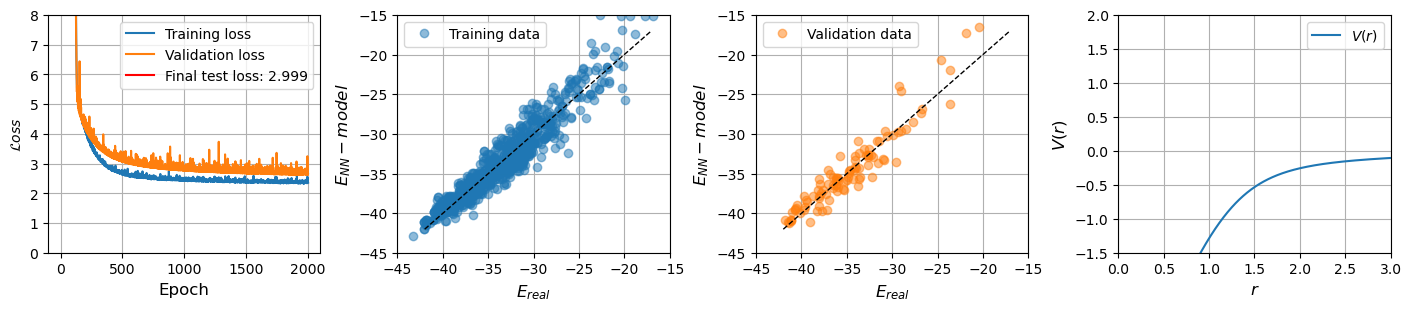

In [17]:
fig, axs = plt.subplots(1,4, figsize=(14,3), layout="constrained")
for ax in axs:
    ax.grid()

axs[0].set_ylim([0.0,8.0])
axs[0].set_xlabel(r"Epoch", fontsize=12)
axs[0].set_ylabel(r"$\mathcal{L}oss$")

with torch.no_grad():
    xs = torch.linspace(0.0, len(train_losses), len(train_losses))
    axs[0].plot(xs, train_losses, label="Training loss")
    axs[0].plot(xs, val_losses, label="Validation loss")
    axs[0].plot([], [], label=f"Final test loss: {round(test_loss.item(),3)}", c="r")
    for ax, loader, color, label in zip([axs[1], axs[2]], [train_loader, val_loader], ["C0", "C1"], ["Training data", "Validation data"]):
        ax.set_xlim([-45,-15])
        ax.set_ylim([-45,-15])
        ax.set_xlabel(r"$E_{real}$", fontsize=12)
        ax.set_ylabel(r"$E_{NN}-model$", fontsize=12)
        i = 0
        for coords, energies in loader:
            e_model = models[0].forward(coords)
            if i == 0:
                ax.plot(e_model, energies, 'o', color=color, alpha=0.5, label=label)
            else:
                ax.plot(e_model, energies, 'o', color=color, alpha=0.5)
            i+=1
        xs = np.linspace(-42, -17, 100)
        ax.plot(xs, xs, c="k", lw=1, ls="--")
        ax.legend()
    rs = torch.linspace(0.2, 4.0, 1000).view(-1,1)
    axs[3].set_xlabel(r"$r$", fontsize=12)
    axs[3].set_ylabel(r"$V(r)$", fontsize=12)
    axs[3].set_ylim([-1.5,2.0])
    axs[3].set_xlim([0.0,3.0])
    axs[3].plot(rs, models[0]._V(rs), label=r"$V(r)$")
    axs[3].legend()
    axs[0].legend()